In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Exploratory Data Analysis (EDA)

**Tasks:**

1. Check Summary Statistics for the Dataset
2. Check Distribution Of Classes
3. Check Correlation Matrix
4. Check For Outliers
5. Visualize Data After Dimension Reduction

In [166]:
df = pd.read_csv('./bank+marketing/bank/bank-full.csv', sep=';')
df.drop(columns=['month', 'day'], inplace=True)
df.drop_duplicates(inplace=True)

In [167]:
df.replace('unknown', np.nan, inplace=True)

In [168]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,198,1,-1,0,NaN,no


In [169]:
df.isnull().sum()

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
duration         0
campaign         0
pdays            0
previous         0
poutcome     36958
y                0
dtype: int64

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45210 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45210 non-null  int64 
 1   job        44922 non-null  object
 2   marital    45210 non-null  object
 3   education  43353 non-null  object
 4   default    45210 non-null  object
 5   balance    45210 non-null  int64 
 6   housing    45210 non-null  object
 7   loan       45210 non-null  object
 8   contact    32190 non-null  object
 9   duration   45210 non-null  int64 
 10  campaign   45210 non-null  int64 
 11  pdays      45210 non-null  int64 
 12  previous   45210 non-null  int64 
 13  poutcome   8252 non-null   object
 14  y          45210 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [180]:
#  TODO: 
df.describe()

,age,balance,duration,campaign,pdays,previous
count,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000
mean,40.935921,1362.302190,258.164057,2.763835,40.198739,0.580336
std,10.618702,3044.792762,257.530577,3.098055,100.129666,2.303465
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


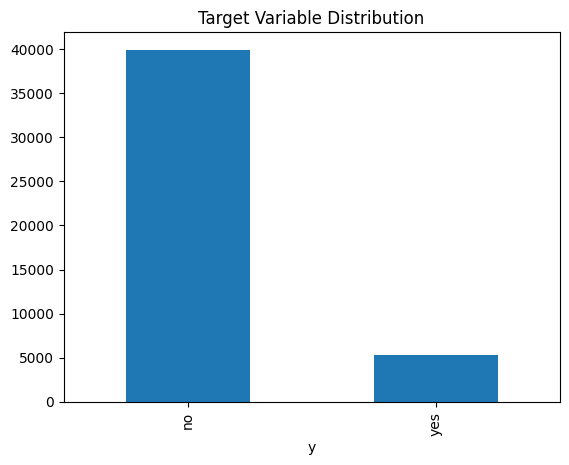

In [172]:
#  TODO: 
# Distribution of target variable
df['y'].value_counts().plot(kind='bar', title='Target Variable Distribution')
plt.show()

In [175]:
#  TODO: Check for class imbalance
print("\nClass Distribution:\n", df['y'].value_counts())
print(df['y'].value_counts(normalize=True))


Class Distribution:
 y
no     39921
yes     5289
Name: count, dtype: int64
y
no     0.883013
yes    0.116987
Name: proportion, dtype: float64


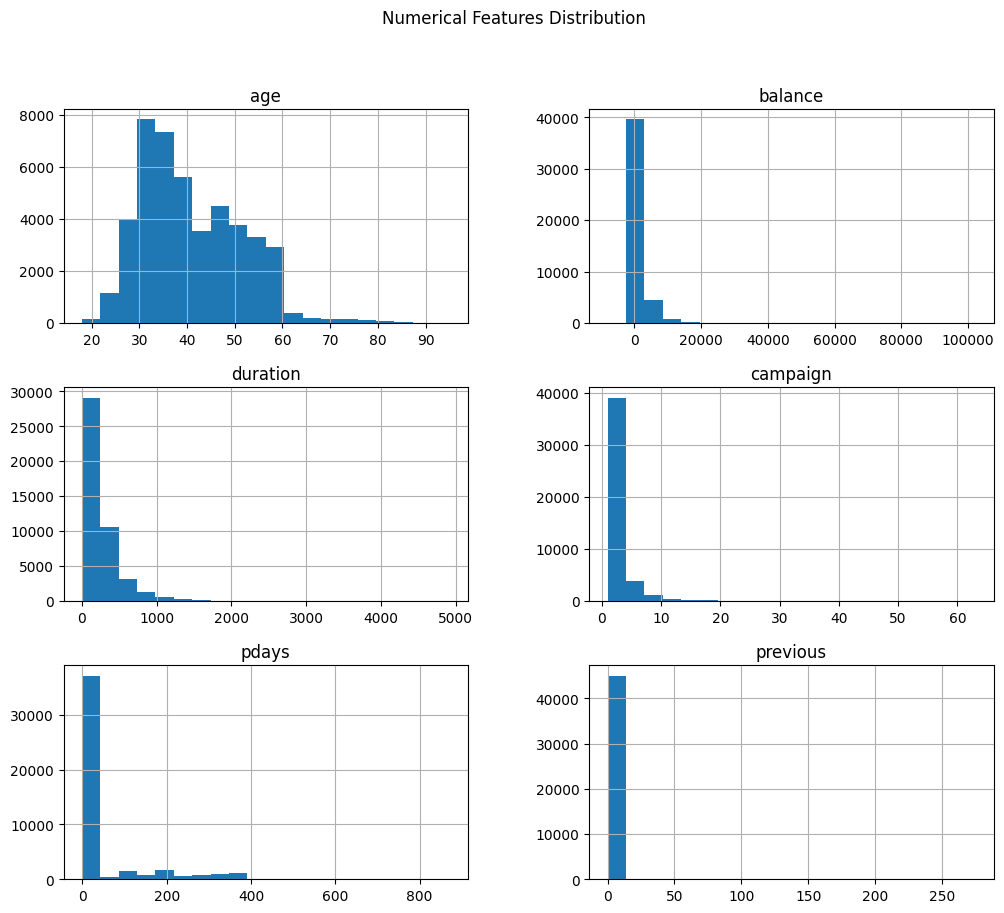

In [176]:
# Visualize numerical features
numeric_features = df.select_dtypes(include=[np.number])
numeric_features.hist(figsize=(12, 10), bins=20)
plt.suptitle("Numerical Features Distribution")
plt.show()

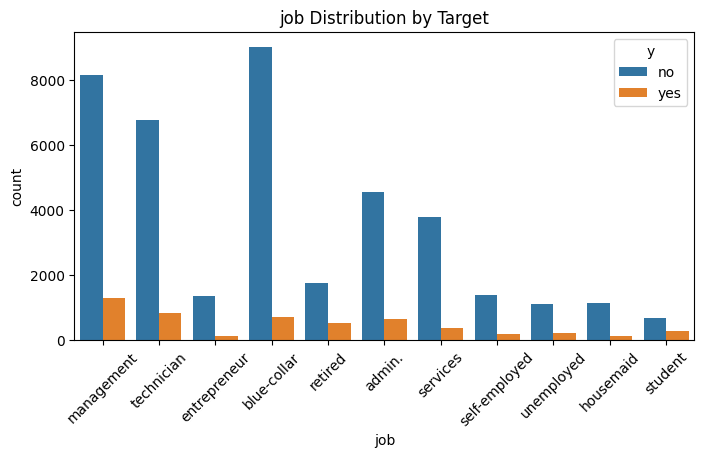

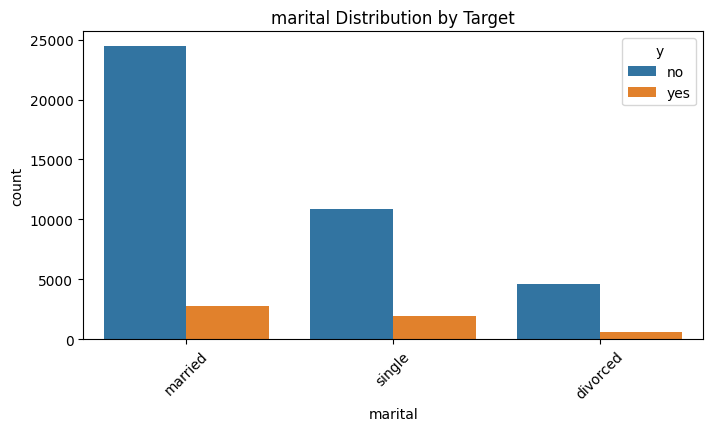

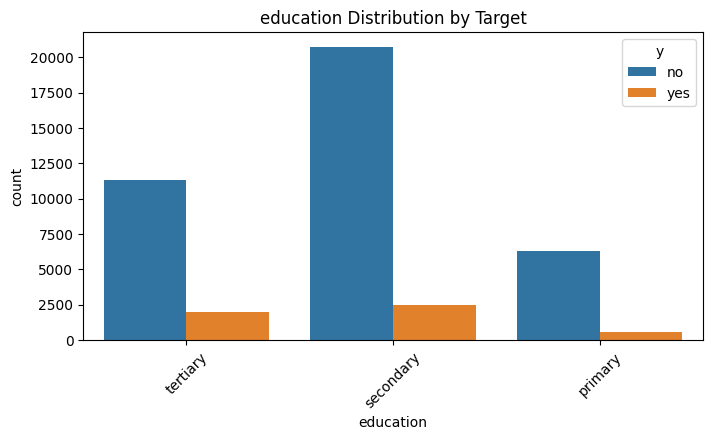

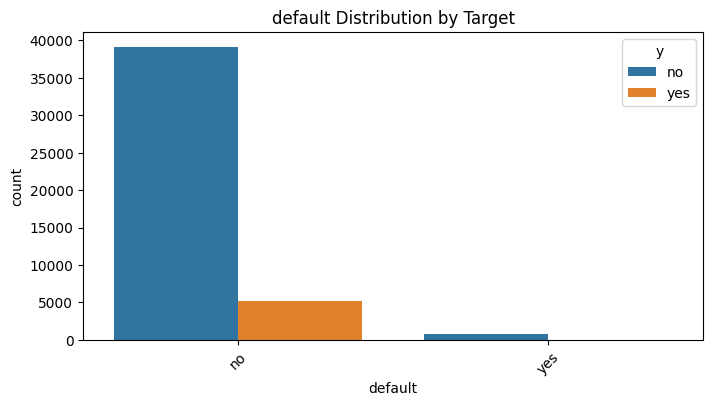

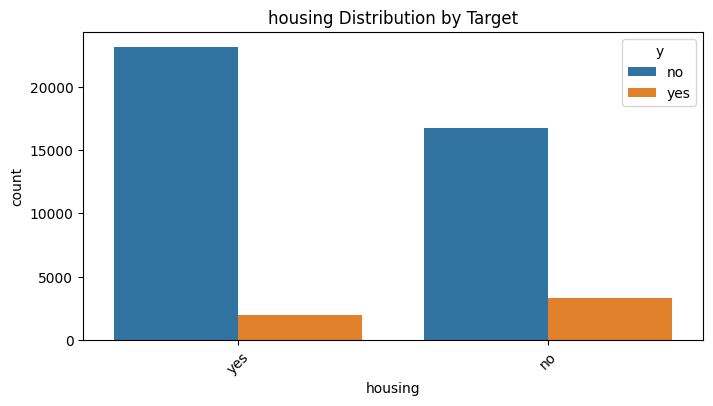

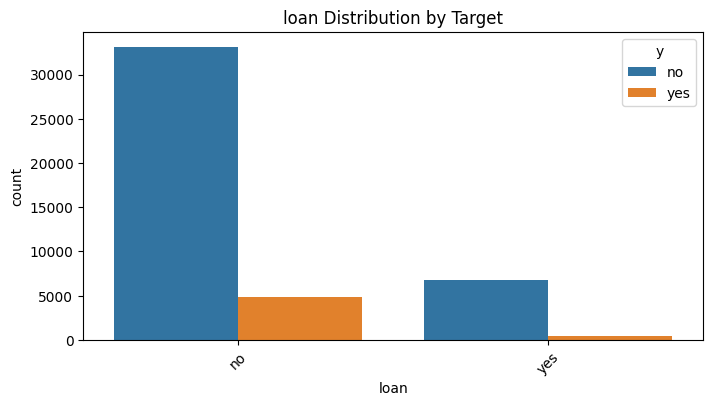

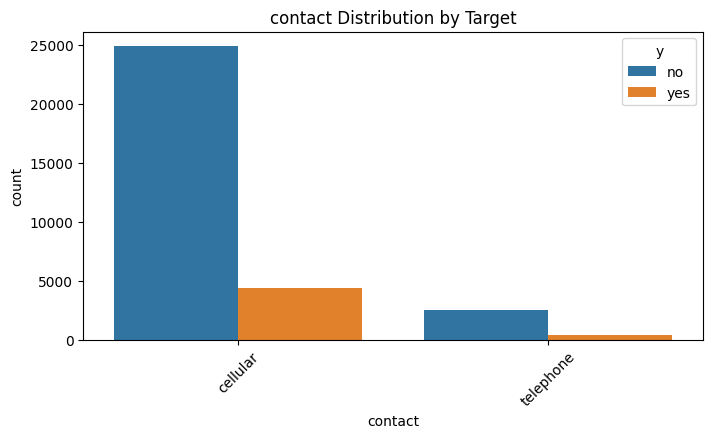

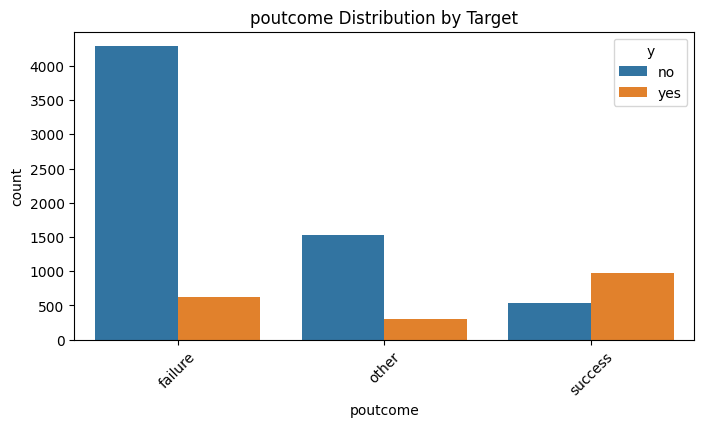

In [177]:
# Categorical variable distributions
categorical_features = df.select_dtypes(include=['object']).columns.drop('y')
for col in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df[col], hue=df['y'])
    plt.xticks(rotation=45)
    plt.title(f"{col} Distribution by Target")
    plt.show()

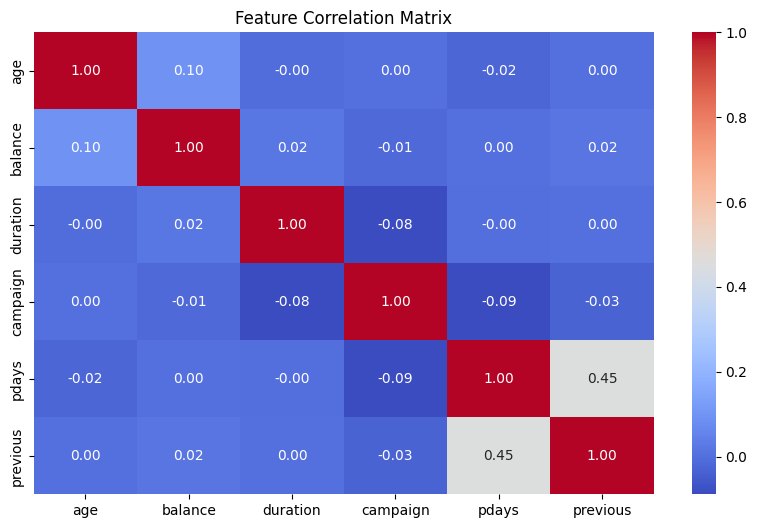

In [181]:
#  TODO:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_features.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

## Preprocess

In [90]:
from sklearn.impute import SimpleImputer

In [91]:
# Handle missing values
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].fillna(df[categorical_features].mode().iloc[0])
numeric_features = df.select_dtypes(include=[np.number])
num_imputer = SimpleImputer(strategy='mean')
df[numeric_features.columns] = num_imputer.fit_transform(numeric_features)

In [92]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [93]:
from sklearn.ensemble import IsolationForest

# Detect outliers using Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_preds = iso_forest.fit_predict(df.select_dtypes(include=[np.number]))
df["outlier"] = outlier_preds

# Remove detected outliers
df = df[df["outlier"] == 1].drop(columns=["outlier"])

In [94]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

In [95]:
# Encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_encoded = pd.DataFrame(encoder.fit_transform(df[categorical_features.drop('y')]))
categorical_encoded.columns = encoder.get_feature_names_out(categorical_features.drop('y'))
df = df.drop(columns=categorical_features.drop('y')).join(categorical_encoded)

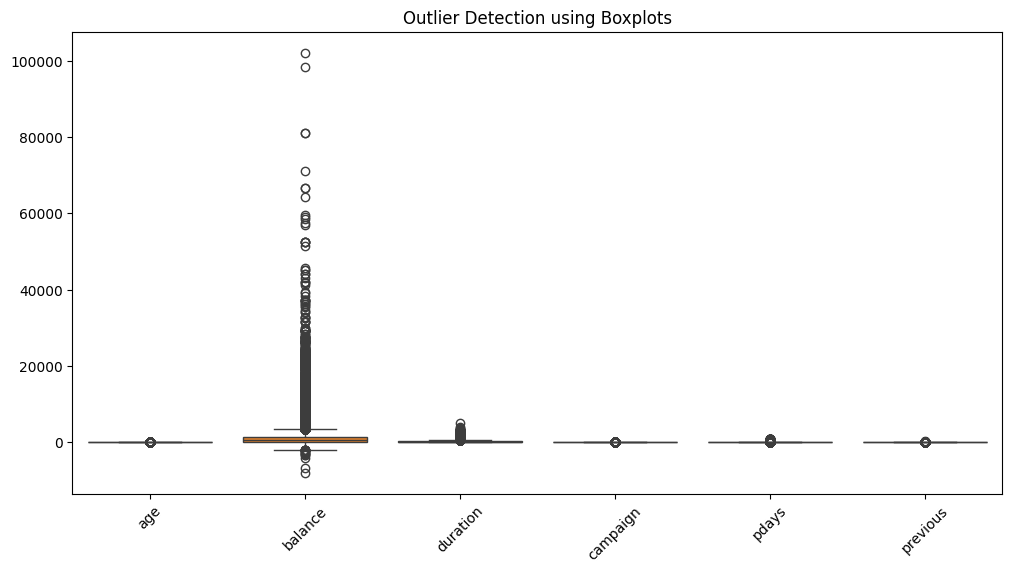

In [178]:
# Outlier detection using IQR
Q1 = numeric_features.quantile(0.25)
Q3 = numeric_features.quantile(0.75)
IQR = Q3 - Q1
outliers = ((numeric_features < (Q1 - 1.5 * IQR)) | (numeric_features > (Q3 + 1.5 * IQR)))
plt.figure(figsize=(12, 6))
sns.boxplot(data=numeric_features)
plt.xticks(rotation=45)
plt.title("Outlier Detection using Boxplots")
plt.show()

In [96]:
df.isnull().sum()

age                       0
balance                   0
duration                  0
campaign                  0
pdays                     0
previous                  0
y                         0
job_blue-collar        1687
job_entrepreneur       1687
job_housemaid          1687
job_management         1687
job_retired            1687
job_self-employed      1687
job_services           1687
job_student            1687
job_technician         1687
job_unemployed         1687
marital_married        1687
marital_single         1687
education_secondary    1687
education_tertiary     1687
default_yes            1687
housing_yes            1687
loan_yes               1687
contact_telephone      1687
poutcome_other         1687
poutcome_success       1687
dtype: int64

In [97]:
# Handle missing values
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = df[categorical_features].fillna(df[categorical_features].mode().iloc[0])
numeric_features = df.select_dtypes(include=[np.number])
num_imputer = SimpleImputer(strategy='mean')
df[numeric_features.columns] = num_imputer.fit_transform(numeric_features)

In [98]:
df.isnull().sum()

age                    0
balance                0
duration               0
campaign               0
pdays                  0
previous               0
y                      0
job_blue-collar        0
job_entrepreneur       0
job_housemaid          0
job_management         0
job_retired            0
job_self-employed      0
job_services           0
job_student            0
job_technician         0
job_unemployed         0
marital_married        0
marital_single         0
education_secondary    0
education_tertiary     0
default_yes            0
housing_yes            0
loan_yes               0
contact_telephone      0
poutcome_other         0
poutcome_success       0
dtype: int64

In [99]:
df.columns

Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'y',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_secondary', 'education_tertiary',
       'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone',
       'poutcome_other', 'poutcome_success'],
      dtype='object')

In [160]:
df.describe()

,age,balance,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,marital_married,marital_single,education_secondary,education_tertiary,default_yes,housing_yes,loan_yes,contact_telephone,poutcome_other,poutcome_success
count,42949.000000,42949.000000,42949.000000,42949.00000,42949.000000,42949.000000,42949.000000,42949.000000,42949.000000,42949.000000,...,42949.000000,42949.000000,42949.000000,42949.000000,42949.000000,42949.000000,42949.000000,42949.000000,42949.000000,42949.000000
mean,40.719714,1237.683834,251.829216,2.60644,31.210599,0.329274,0.224880,0.033445,0.028162,0.207988,...,0.604091,0.280355,0.557099,0.291915,0.018807,0.556880,0.164122,0.059328,0.029179,0.025205
std,10.297204,2571.458277,244.561819,2.44302,87.167628,0.947802,0.409226,0.176231,0.162154,0.397822,...,0.479350,0.440268,0.486881,0.445630,0.133149,0.486906,0.363043,0.231555,0.164972,0.153639
min,18.000000,-8019.000000,0.000000,1.00000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,67.000000,103.000000,1.00000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,431.000000,178.000000,2.00000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,48.000000,1356.000000,312.000000,3.00000,-1.000000,0.000000,0.224880,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,95.000000,102127.000000,3881.000000,25.00000,842.000000,8.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [100]:
# Encode target variable
y = LabelEncoder().fit_transform(df['y'])
df.drop(columns=['y'], inplace=True)

In [101]:
df.columns

Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_secondary', 'education_tertiary',
       'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone',
       'poutcome_other', 'poutcome_success'],
      dtype='object')

In [102]:
# Standardize numerical features
scaler = StandardScaler()
X = scaler.fit_transform(df)

In [103]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import seaborn as sns

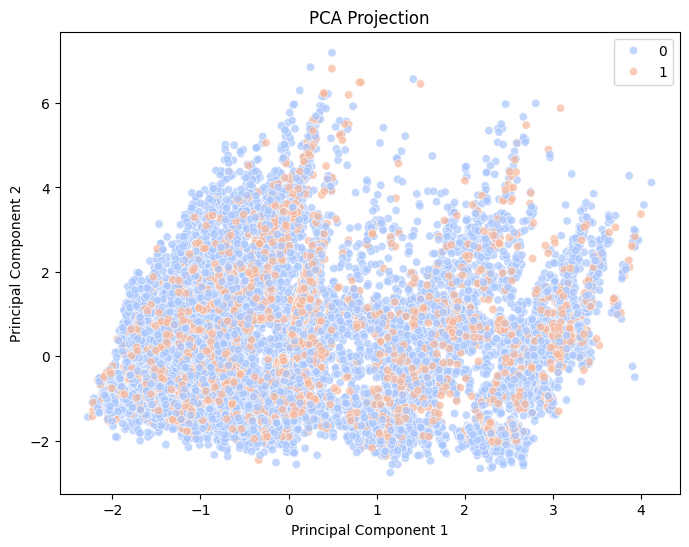

In [104]:
# Apply PCA for Dimensionality Reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm', alpha=0.7)
plt.title("PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

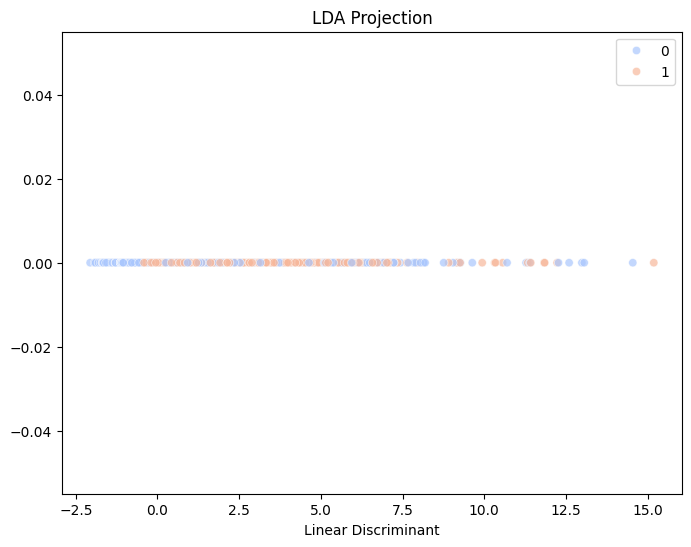

In [105]:
# Apply LDA for Dimensionality Reduction
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X, y)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_lda[:, 0], y=np.zeros_like(X_lda[:, 0]), hue=y, palette='coolwarm', alpha=0.7)
plt.title("LDA Projection")
plt.xlabel("Linear Discriminant")
plt.show()

In [106]:
from sklearn.model_selection import train_test_split
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Learning Models

### SVM

In [107]:
from sklearn.svm import SVC

In [108]:
# Train SVM model
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [109]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [110]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("SVM Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

SVM Model Performance:
Accuracy: 0.8998
Precision: 0.5943
Recall: 0.2052
F1 Score: 0.3051
Confusion Matrix:
[[7540  129]
 [ 732  189]]


### Ensemble Learning

In [111]:
import xgboost as xgb

In [112]:
# Convert the dataset into DMatrix format (XGBoost's optimized data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [113]:
# Define the parameters for the model
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 3,  # 3 classes in the Iris dataset
    'eval_metric': 'merror',  # Metric to evaluate the performance
}

# Train the model
num_round = 50  # Number of boosting rounds
bst = xgb.train(params, dtrain, num_round)

In [74]:
# Make predictions
preds = bst.predict(dtest)

In [78]:
# Calculate metrics
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
conf_matrix = confusion_matrix(y_test, preds)

print("SVM Model Performance:")
print(f"Accuracy: {accuracy * 100:.2f}")
print(f"Precision: {precision * 100:.2f}")
print(f"Recall: {recall * 100:.2f}")
print(f"F1 Score: {f1 * 100:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

SVM Model Performance:
Accuracy: 89.28
Precision: 56.61
Recall: 36.01
F1 Score: 44.02
Confusion Matrix:
[[7692  292]
 [ 677  381]]


### Manually Combined Model

In [117]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)


In [143]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Cross-validation and evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate_model(model, X, y):
    accuracy = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    precision = cross_val_score(model, X, y, cv=cv, scoring='precision')
    recall = cross_val_score(model, X, y, cv=cv, scoring='recall')
    f1 = cross_val_score(model, X, y, cv=cv, scoring='f1')
    return {
        "accuracy": (accuracy.mean(), accuracy.std()),
        "precision": (precision.mean(), precision.std()),
        "recall": (recall.mean(), recall.std()),
        "f1": (f1.mean(), f1.std())
    }

In [144]:
svm_score = evaluate_model(svm_model, X_train, y_train)
rf_score = evaluate_model(rf_model, X_train, y_train)

In [ ]:
# xgb_score = evaluate_model(xgb_model, X_train, y_train) # ERROR.  I don't know why???????????????????????????????????

In [145]:
# Ensemble model using majority voting
ensemble_model = VotingClassifier(estimators=[
    ('svm', svm_model),
    ('rf', rf_model),
    # ('xgb', xgb_model)
], voting='hard')
ensemble_score = evaluate_model(ensemble_model, X_train, y_train)

### Test Set

In [147]:
# Display results
results_df = pd.DataFrame({
    "Model": ["SVM", "Random Forest", "Ensemble (Voting)"],
    "Accuracy": [svm_score, rf_score, ensemble_score]
})
print(results_df)


               Model                                           Accuracy
0                SVM  {'accuracy': (0.9022964022331375, 0.0018663260...
1      Random Forest  {'accuracy': (0.904100885281715, 0.00218665970...
2  Ensemble (Voting)  {'accuracy': (0.9026164953375773, 0.0005984817...


In [ ]:
# Display results
results_df = pd.DataFrame({
    "Model": ["SVM (rbf)", "Random Forest", "XGBoost", "Ensemble (Voting)"],
    "Preprocessing": ["Missing Values (Method), PCA, etc.", "Forward Feature Selection", "Missing Values (Method), PCA, etc.", "Combination of SVM, RF, XGB"],
    "Accuracy": [f"{svm_score['accuracy'][0]:.2f} ± {svm_score['accuracy'][1]:.2f}",
                  f"{rf_score['accuracy'][0]:.2f} ± {rf_score['accuracy'][1]:.2f}",
                #   f"{xgb_results['accuracy'][0]:.2f} ± {xgb_results['accuracy'][1]:.2f}",
                  f"{ensemble_score['accuracy'][0]:.2f} ± {ensemble_score['accuracy'][1]:.2f}"],
    "Precision": [f"{svm_score['precision'][0]:.2f} ± {svm_score['precision'][1]:.2f}",
                   f"{rf_score['precision'][0]:.2f} ± {rf_score['precision'][1]:.2f}",
                #    f"{xgb_results['precision'][0]:.2f} ± {xgb_results['precision'][1]:.2f}",
                   f"{ensemble_score['precision'][0]:.2f} ± {ensemble_score['precision'][1]:.2f}"],
    "Recall": [f"{svm_score['recall'][0]:.2f} ± {svm_score['recall'][1]:.2f}",
                f"{rf_score['recall'][0]:.2f} ± {rf_score['recall'][1]:.2f}",
                # f"{xgb_results['recall'][0]:.2f} ± {xgb_results['recall'][1]:.2f}",
                f"{ensemble_score['recall'][0]:.2f} ± {ensemble_score['recall'][1]:.2f}"],
    "F1-score": [f"{svm_score['f1'][0]:.2f} ± {svm_score['f1'][1]:.2f}",
                  f"{rf_score['f1'][0]:.2f} ± {rf_score['f1'][1]:.2f}",
                #   f"{xgb_results['f1'][0]:.2f} ± {xgb_results['f1'][1]:.2f}",
                  f"{ensemble_score['f1'][0]:.2f} ± {ensemble_score['f1'][1]:.2f}"],
})

In [156]:
print(svm_score['accuracy'][0], svm_score['f1'][0], svm_score['precision'][0], svm_score['recall'][0])
print(rf_score['accuracy'][0], rf_score['f1'][0], rf_score['precision'][0], rf_score['recall'][0])
print(ensemble_score['accuracy'][0], ensemble_score['f1'][0], ensemble_score['precision'][0], ensemble_score['recall'][0])


0.9022964022331375 0.30495338832310764 0.6441643449458887 0.20010508229602975
0.904100885281715 0.41098325219523585 0.6026598251922121 0.31224448410123296
0.9026164953375773 0.27302702881854873 0.683902334161185 0.1707786413780898
